# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

Objective: Determine which vehicle attributes most strongly influence used‐car resale values so the dealership can price inventory competitively and highlight high‐value features.

In data‐mining terms, our business objective—“identify what consumers value in a used car”—becomes a supervised regression problem in which price is the target variable and vehicle attributes (age, mileage, make/model, trim, condition, features, etc.) are the explanatory variables. Our goal is to assemble a clean, feature‐engineered dataset of past sales and then fit and validate regression models (e.g. linear models, tree ensembles) to predict listing price. Finally, by examining model coefficients or feature‐importance scores (and, if desired, SHAP values), we’ll quantify which attributes drive the largest price differentials.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. **Inventory & Initial Loading**  
   - Inspect file structure (CSV, delimiters, encoding).  
   - Load into a DataFrame (e.g., with `pandas.read_csv`) and confirm row-count matches expectations.

In [1]:
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load the CSV and inspect shape
df = pd.read_csv("data/vehicles.csv", encoding="utf-8")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 426880, Columns: 18


2. **Schema & Metadata Review**  
   - List column names, data types, and non-null counts.  
   - Annotate each field as continuous vs. categorical, and as target vs. predictor.

In [2]:
# Overview of columns, types, and non-null counts
df.info()

# Data types and null counts
print(df.dtypes)
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

3. **Preview & Value Checks**  
   - Pick values that are within acceptable range: 10th to 95th percentile for 'price'
   - View the first/last few records to verify formatting and spot anomalies (e.g. stray headers).  
   - Check for duplicate rows and invalid values (e.g. `year > 2025`).

In [3]:
df["price"].describe([0.0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)
p10 = df['price'].quantile(0.10)
p95 = df['price'].quantile(0.95)
df_filtered = df[(df['price'] >= p10) & (df['price'] <= p95)].copy()
n_dropped = len(df) - len(df_filtered)
print(f"Dropped {n_dropped} rows; {len(df_filtered)} remain within the 10–95th percentile range.")

df = df_filtered

Dropped 63405 rows; 363475 remain within the 10–95th percentile range.


In [4]:
# Check for duplicates
n_dupes = df.duplicated().sum()
print(f"Duplicate rows: {n_dupes}")

from datetime import datetime
current_year = datetime.now().year

# Spot invalid values in key columns
print(df[ (df["year"] > current_year)]) 

Duplicate rows: 0
Empty DataFrame
Columns: [id, region, price, year, manufacturer, model, condition, cylinders, fuel, odometer, title_status, transmission, VIN, drive, size, type, paint_color, state]
Index: []


4. **Missingness Analysis**  
   - Compute per-column percentage of missing values.  
   - Visualize patterns (e.g. a missingness heatmap) to detect systematic gaps.

size           71.238
cylinders      40.389
VIN            39.527
condition      36.556
drive          30.804
paint_color    28.864
type           21.579
manufacturer    3.834
title_status    1.813
model           1.102
fuel            0.666
odometer        0.539
transmission    0.465
year            0.200
id              0.000
region          0.000
price           0.000
state           0.000
dtype: float64


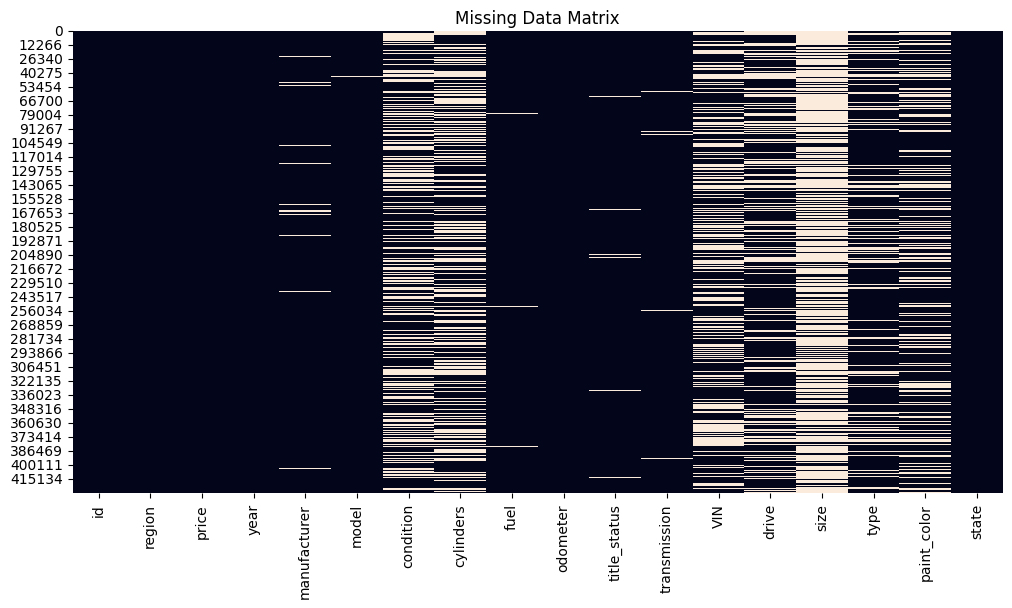

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Percent missing per column
missing_pct = df.isnull().mean() * 100
print(missing_pct.sort_values(ascending=False))

# Heatmap of missingness
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Data Matrix")
plt.show()

5. **Univariate Summaries**  
   - **Continuous fields** (`mileage`, `engine_size`, `price`):  
     - Calculate summary stats (min, quartiles, max).  
     - Plot histograms or boxplots to spot skew and outliers.  
   - **Categorical fields** (`make`, `model`, `transmission`):  
     - Compute value counts and unique levels.  
     - Look for typos or inconsistent labels (e.g. “Honda” vs. “honda”).

           price     odometer       year
count 363475.000   361515.000 362747.000
mean   17026.902   101381.638   2010.708
std    11285.003   195546.337      9.496
min      500.000        0.000   1900.000
25%     7450.000    41361.500   2008.000
50%    14950.000    91400.000   2013.000
75%    25590.000   138755.000   2016.000
max    44500.000 10000000.000   2022.000


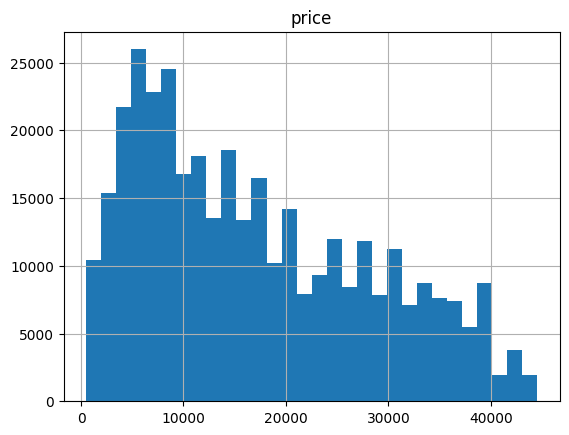

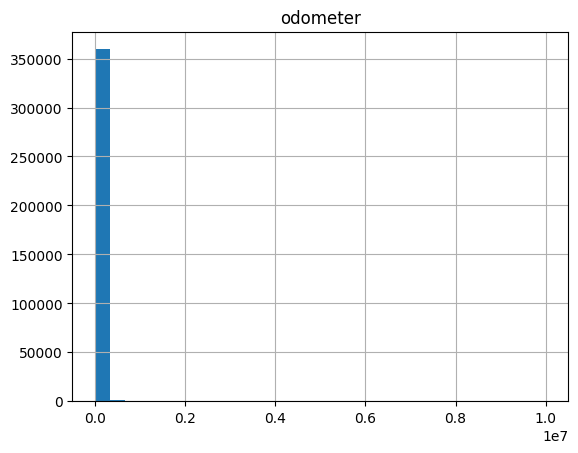

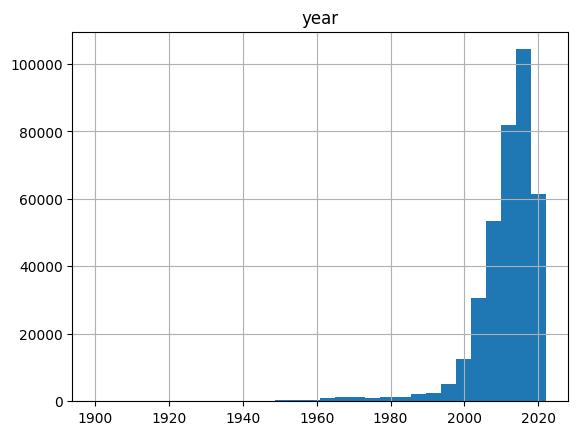


Top values in size:
size
full-size      54026
mid-size       31117
compact        16618
sub-compact     2781
Name: count, dtype: int64

Top values in model:
model
f-150             6503
silverado 1500    4170
1500              3445
camry             2745
accord            2657
civic             2517
silverado         2489
escape            2474
altima            2404
wrangler          2396
Name: count, dtype: int64

Top values in drive:
drive
4wd    104755
fwd     94862
rwd     51894
Name: count, dtype: int64

Top values in transmission:
transmission
automatic    280743
other         58872
manual        22169
Name: count, dtype: int64


In [6]:
# Continuous fields
numeric_cols = ["price", "odometer", "year"]
print(df[numeric_cols].describe())

for col in numeric_cols:
    df[col].hist(bins=30)
    plt.title(col)
    plt.show()

# Categorical fields
cat_cols = ["size", "model", "drive", "transmission"]
for col in cat_cols:
    counts = df[col].value_counts().head(10)
    print(f"\nTop values in {col}:\n{counts}")

6. **Date & Derived Fields**  

| Column Name              | Description                                                                  |
|--------------------------|------------------------------------------------------------------------------|
| `age_years`              | Vehicle age in years (current calendar year – model year)                    |
| `odometer_km`            | Odometer reading converted from miles to kilometers                          |
| `mileage_per_year`       | Average annual mileage (`odometer` ÷ `age_years`)                            |
| `price_per_mile`         | Price normalized by usage (`price` ÷ `odometer`)                             |
| `has_vin`                | Binary indicator (1/0) for presence of a VIN                                 |
| `is_automatic`           | Binary indicator if `transmission` contains “auto”                           |
| `is_title_clean`         | Binary indicator if `title_status` == “clean”                                |
| `drive_4wd`, `drive_fwd`, `drive_rwd` | One-hot indicators for drive type (`drive`)                     |
| `fuel_electric`, `fuel_hybrid`, `fuel_diesel` | One-hot indicators for key fuel types (`fuel`)          |
| `manufacturer_model`     | Concatenation of `manufacturer` and `model`                                  |
| `region_state`           | Combined `region` and `state` (e.g. “sfbay_CA”)                              |
| `condition_missing`      | Binary indicator if `condition` is missing                                   |
| `cylinders_num`          | Numeric cylinder count extracted from the text `cylinders` field             |
| `age_bucket`             | Binned age categories (e.g. ‘0–5’, ‘6–10’, ‘11–20’, ‘20+’)                   |

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime

# Assume df is your DataFrame loaded already

# 1. Age in years
df['age_years'] = datetime.now().year - df['year']

# 3. Average annual mileage
df['mileage'] = df['odometer'] / df['age_years'].replace(0, np.nan)

# 4. Price per mile
df['price_per_mile'] = df['price'] / df['odometer'].replace(0, np.nan)

# 5. VIN presence indicator
df['has_vin'] = df['VIN'].notna().astype(int)

# 6. Automatic transmission indicator
df['is_automatic'] = df['transmission']\
    .str.contains('auto', case=False, na=False).astype(int)

# 7. Clean title indicator
df['is_title_clean'] = (df['title_status'] == 'clean').astype(int)

# 8. One-hot drive types
df['drive_4wd'] = (df['drive'] == '4wd').astype(int)
df['drive_fwd'] = (df['drive'] == 'fwd').astype(int)
df['drive_rwd'] = (df['drive'] == 'rwd').astype(int)

# 9. One-hot key fuel types
df['fuel_electric'] = (df['fuel'] == 'electric').astype(int)
df['fuel_hybrid'] = df['fuel'].str.contains('hybrid', case=False, na=False).astype(int)
df['fuel_diesel'] = (df['fuel'] == 'diesel').astype(int)

# 10. Combined manufacturer & model
df['manufacturer_model'] = df['manufacturer'].fillna('') + '_' + df['model'].fillna('')

# 11. Combined region & state
df['region_state'] = df['region'] + '_' + df['state']

# 12. Condition missingness indicator
df['condition_missing'] = df['condition'].isna().astype(int)

# 13. Numeric cylinders
df['cylinders_num'] = df['cylinders']\
    .str.extract(r'(\d+)').astype(float)

# 14. Age buckets
df['age_bucket'] = pd.cut(
    df['age_years'],
    bins=[-1, 5, 10, 20, np.inf],
    labels=['0–5','6–10','11–20','20+']
)

7. **Inter-field Consistency**  
   - Cross-check related fields:  
     - `mileage` vs. `price`
     - `transmission` vs. `price`
     - `age` vs. `price`

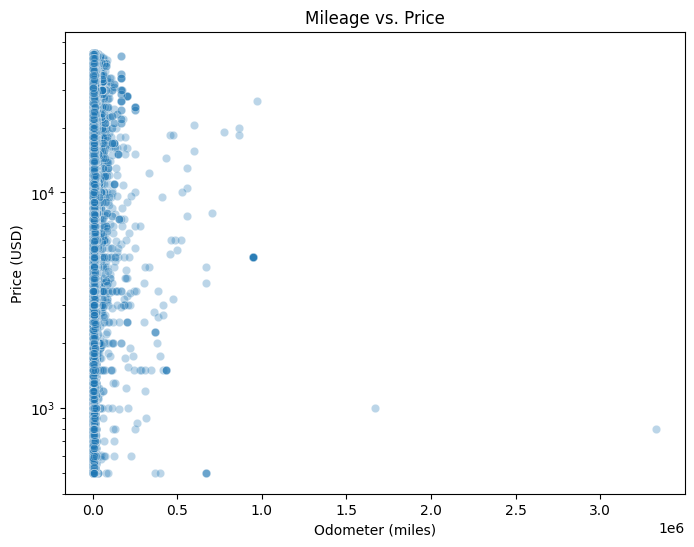

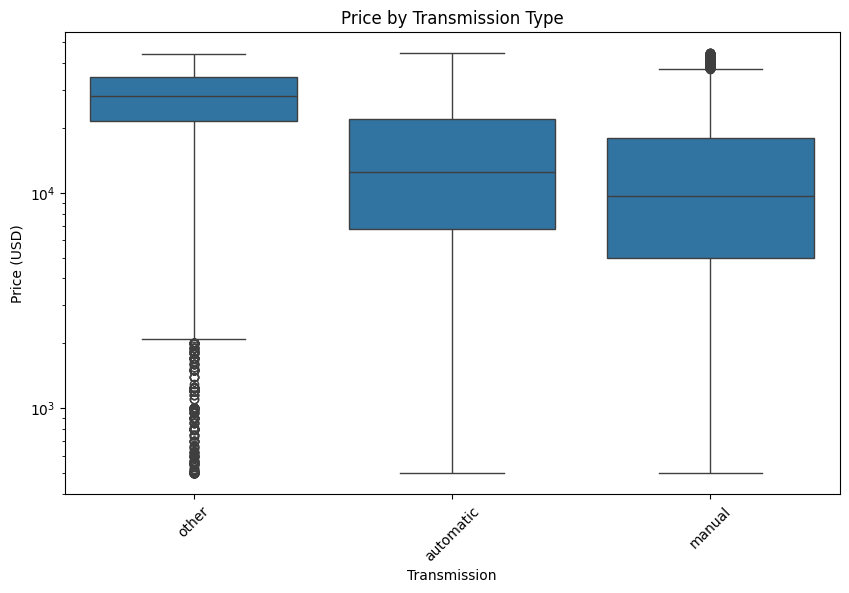

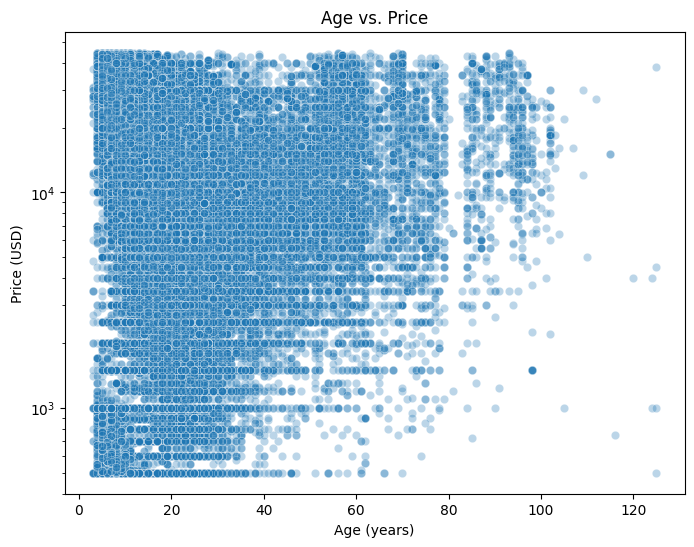

In [8]:
# 1. Mileage vs. Price
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='mileage',
    y='price',
    data=df,
    alpha=0.3
)
plt.title('Mileage vs. Price')
plt.yscale('log')
plt.xlabel('Odometer (miles)')
plt.ylabel('Price (USD)')
plt.show()

# 2. Transmission vs. Price
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='transmission',
    y='price',
    data=df
)
plt.title('Price by Transmission Type')
plt.yscale('log')
plt.xlabel('Transmission')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.show()

# 3. Age vs. Price
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='age_years',
    y='price',
    data=df,
    alpha=0.3
)
plt.title('Age vs. Price')
plt.yscale('log')
plt.xlabel('Age (years)')
plt.ylabel('Price (USD)')
plt.show()

8. **Correlation & Bivariate Exploration**  
   - Compute Pearson/Spearman correlations among numeric predictors and with `price`.  
   - Scatterplots of `price` vs. key continuous features (`mileage`, `age`).  
   - Boxplots of `price` by categorical levels (`make`, `transmission`).

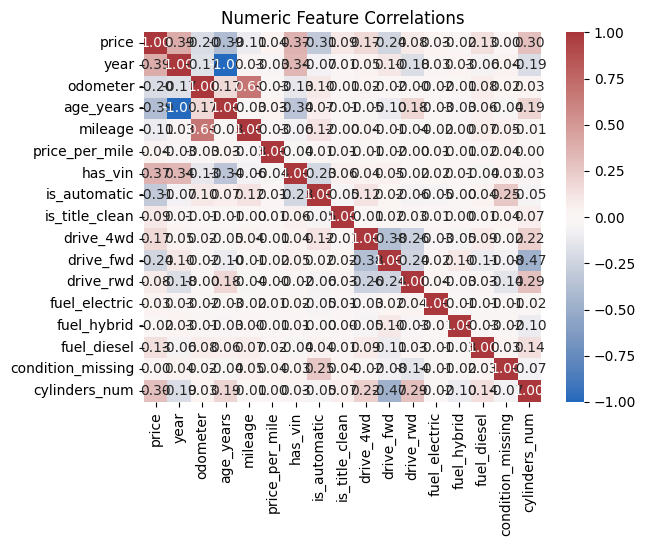

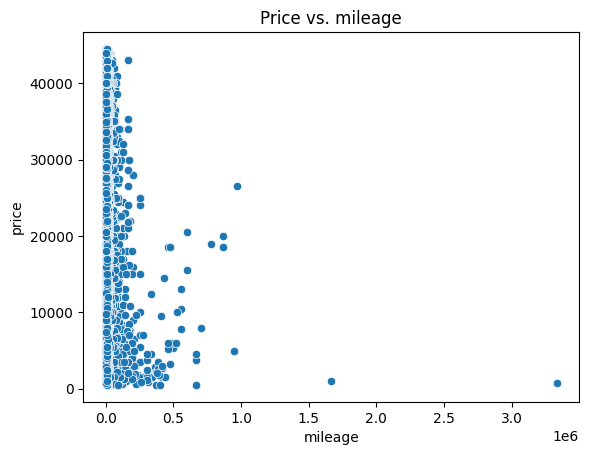

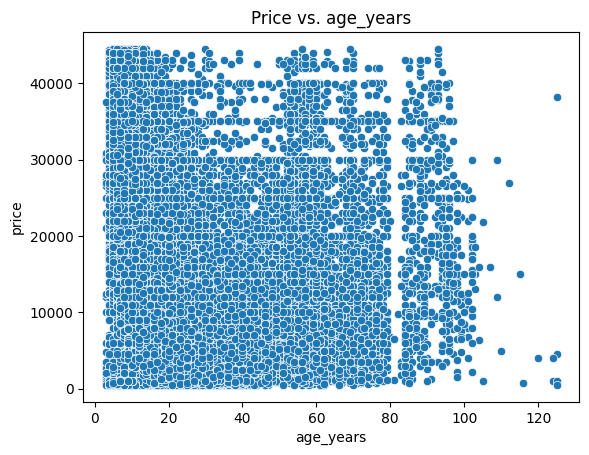

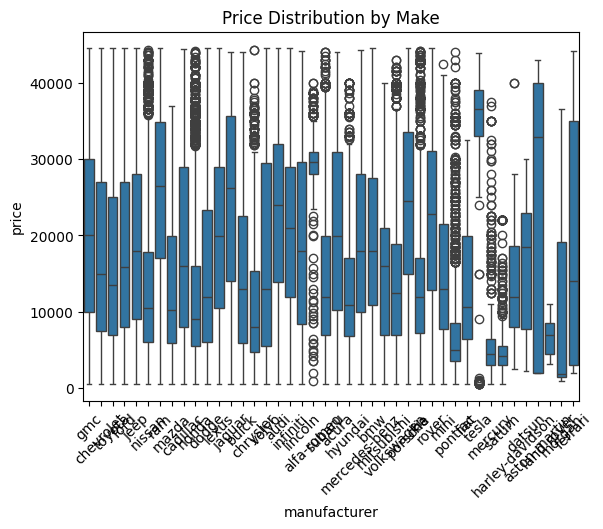

In [9]:
import numpy as np

# Numeric correlation matrix
num_df = df.select_dtypes(include=[np.number]).drop(columns=["id"], errors="ignore")
corr = num_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Numeric Feature Correlations")
plt.show()

# Price vs. key predictors
for col in ["mileage", "age_years"]:
    sns.scatterplot(x=col, y="price", data=df)
    plt.title(f"Price vs. {col}")
    plt.show()

# Price by make
sns.boxplot(x="manufacturer", y="price", data=df)
plt.xticks(rotation=45)
plt.title("Price Distribution by Make")
plt.show()

9. **Outlier & Anomaly Detection**  
   - Identify extreme values in `price` or `mileage` that may be entry errors.  
   - Decide on trimming or capping rules (e.g. cap `mileage` at the 99th percentile).

In [10]:
# Identify and cap extreme mileage at 99th percentile
m99 = df["mileage"].quantile(0.99)
df["mileage_capped"] = np.where(df["mileage"] > m99, m99, df["mileage"])

# Price outliers via IQR
Q1, Q3 = df["price"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = df[(df["price"] < lower) | (df["price"] > upper)]
print(f"Price outliers: {outliers.shape[0]}")

Price outliers: 0



10. **Data Quality Report**  
    - Summarize which fields are clean vs. need imputation.  
    - Flag high-cardinality or noisy columns and propose treatments (e.g. group rare models into “Other”).  
    - Document any fields to drop or recast before modeling.

In [11]:
# Compile a summary table of quality metrics
quality = pd.DataFrame({
    "dtype":     df.dtypes,
    "missing%":  df.isnull().mean()*100,
    "n_unique":  df.nunique()
})
print(quality.sort_values("missing%", ascending=False))

# List fields to drop or recast
to_drop = quality[quality["missing%"] > 80].index.tolist()
print("High-missing columns to consider dropping:", to_drop)

                       dtype  missing%  n_unique
size                  object    71.238         4
cylinders_num        float64    40.639         7
cylinders             object    40.389         8
VIN                   object    39.527     97059
condition             object    36.556         6
drive                 object    30.804         3
paint_color           object    28.864        12
type                  object    21.579        13
manufacturer          object     3.834        42
title_status          object     1.813         6
model                 object     1.102     25859
price_per_mile       float64     0.813    164294
mileage_capped       float64     0.722    122795
mileage              float64     0.722    124623
fuel                  object     0.666         5
odometer             float64     0.539     93861
transmission          object     0.465         3
age_bucket          category     0.200         4
age_years            float64     0.200       112
year                

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

1. **Deduplicate & Filter**  
   Remove exact duplicates and any records with impossible values.

2. **Handle Missing Values**  
   Impute or drop NA’s in both numeric and categorical fields.

3. **Type Conversion & Date Parsing**  
   Ensure all columns have correct dtypes; parse dates and derive age.

4. **Categorical Encoding**  
   One-hot or target-encode nominal variables (make, model, transmission, etc.).

5. **Feature Engineering**  
   Create mileage-per-year, age², grouping of rare categories, etc.

6. **Transform Skewed Numerics**  
   Apply log or power transforms to heavy-tailed features (mileage, price if desired).

7. **Scaling**  
   Standardize or normalize numeric inputs for algorithms sensitive to scale.

8. **Train/Test Split**  
   Reserve a hold-out set before modeling.

9. **Pipeline Assembly**  
   Combine all of the above into an `sklearn` `Pipeline`/`ColumnTransformer` for reproducibility.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1) define which features you really want
numeric_cols = ["mileage", "age_years", "mileage"]
cat_cols     = [
    "manufacturer", "transmission",
    "fuel", "drive", "size", "type", "title_status",
    "condition", "cylinders", "region", "state"
]

# 2) build separate pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

# 3) combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, numeric_cols),
        ("cat", cat_pipeline, cat_cols),
    ],
    remainder="drop"   # drop any other columns not listed above
)

pipeline = Pipeline([
    ("preprocessor", preprocessor)
])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
# Features and target for training set
X_train = df_train.drop(columns=['price'])
y_train = df_train['price']

# Features and target for test set
X_test  = df_test.drop(columns=['price'])
y_test  = df_test['price']


# Fit the preprocessor (and model, if added) on training data
pipeline.fit(X_train, y_train)

# Transform train & test sets
X_train_prepared = pipeline.transform(X_train)
X_test_prepared  = pipeline.transform(X_test)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from joblib import Parallel, delayed
import time

import warnings
warnings.filterwarnings('ignore')  

### Takes 30mins to complete, GradientBoost model training is very time consuming

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42), # 6mins
    'Gradient Boosting': GradientBoostingRegressor(random_state=42) #15mins
}

results = {}

def train_and_eval(name, model, X_tr, y_tr, X_te, y_te):
    start = time.time()
    print(f"Model {name} training started")
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    elapsed = time.time() - start

    mse  = mean_squared_error(y_te, preds)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_te, preds)
    r2   = r2_score(y_te, preds)

    cv_scores = cross_val_score(
        model, X_tr, y_tr, cv=5, scoring='r2', n_jobs=1  # keep CV serial here
    )
    print(f"Model {name} training complete. Time taken = {elapsed} s")

    return name, {
        'RMSE':         rmse,
        'MAE':          mae,
        'R2':           r2,
        'CV_R2_mean':   cv_scores.mean(),
        'CV_R2_std':    cv_scores.std(),
        'train_time_s': elapsed,
        'model':        model
    }

# Kick off all 5 trainings in parallel
results_list = Parallel(n_jobs=5)(
    delayed(train_and_eval)(
        name, 
        # if you want each model to use all cores internally, set n_jobs=-1 on those
        (model.set_params(n_jobs=-1) if hasattr(model, 'n_jobs') else model),
        X_train_prepared, y_train,
        X_test_prepared,  y_test
    )
    for name, model in models.items()
)

# Turn list back into dict
results = dict(results_list)
best = max(results, key=lambda k: results[k]['R2'])
print(f"Best model: {best} (R² = {results[best]['R2']:.4f})")

### Output from Model Training

Model Ridge Regression training complete. Time taken = 1.1825339794158936 s
Model Linear Regression training complete. Time taken = 7.648020029067993 s
Model Lasso Regression training complete. Time taken = 15.873347997665405 s
Model Random Forest training complete. Time taken = 334.3557999134064 s
Model Gradient Boosting training complete. Time taken = 855.8035469055176 s
Best model: Random Forest (R² = 0.8853)

In [14]:
##### Run this to short-circuit and load the results table

import re
import ast
import pandas as pd

results_str = """
{'Linear Regression': {'RMSE': np.float64(6959.105961212615), 'MAE': 5063.014373016406, 'R2': 0.6179700422371557, 'CV_R2_mean': np.float64(0.6150616290399554), 'CV_R2_std': np.float64(0.002658886887092446), 'train_time_s': 7.648020029067993, 'model': LinearRegression(n_jobs=-1)}, 'Ridge Regression': {'RMSE': np.float64(6959.033806402785), 'MAE': 5062.974814401088, 'R2': 0.6179779642766249, 'CV_R2_mean': np.float64(0.6152027527916126), 'CV_R2_std': np.float64(0.002625067210403189), 'train_time_s': 1.1825339794158936, 'model': Ridge()}, 'Lasso Regression': {'RMSE': np.float64(6970.767811351699), 'MAE': 5069.29415640809, 'R2': 0.6166885819281194, 'CV_R2_mean': np.float64(0.6143285305584117), 'CV_R2_std': np.float64(0.002561852136348414), 'train_time_s': 15.873347997665405, 'model': Lasso()}, 'Random Forest': {'RMSE': np.float64(3812.3694802331433), 'MAE': 2011.2429980077814, 'R2': 0.8853483021921651, 'CV_R2_mean': np.float64(0.8762600469263326), 'CV_R2_std': np.float64(0.0013546128648246683), 'train_time_s': 334.3557999134064, 'model': RandomForestRegressor(n_jobs=-1, random_state=42)}, 'Gradient Boosting': {'RMSE': np.float64(6014.643723420198), 'MAE': 4251.344940139024, 'R2': 0.7146286720982911, 'CV_R2_mean': np.float64(0.7139071414456059), 'CV_R2_std': np.float64(0.000817591246934239), 'train_time_s': 855.8035469055176, 'model': GradientBoostingRegressor(random_state=42)}}
"""

# 1) Unwrap the np.float64 calls
cleaned = re.sub(r'np\.float64\(\s*([^)]+?)\s*\)', r'\1', results_str)

# 2) Replace any “ClassName(…)" calls with None so literal_eval can parse
cleaned = re.sub(r'\b[A-Za-z_]+\([^)]*\)', 'None', cleaned)

# 3) Parse into a pure-Python dict
data = ast.literal_eval(cleaned)

# 4) Drop the now-useless 'model' key
for stats in data.values():
    stats.pop('model', None)

# 5) build your DataFrame
results_df = pd.DataFrame(data).T

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

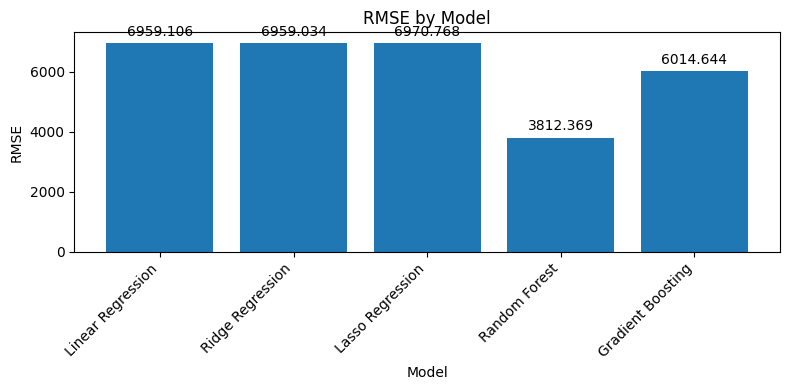

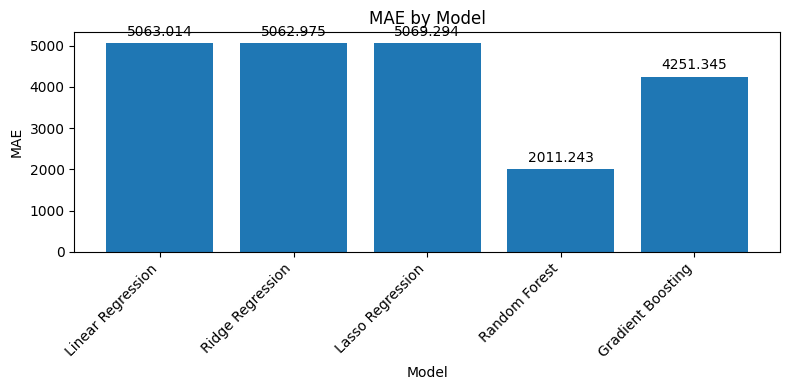

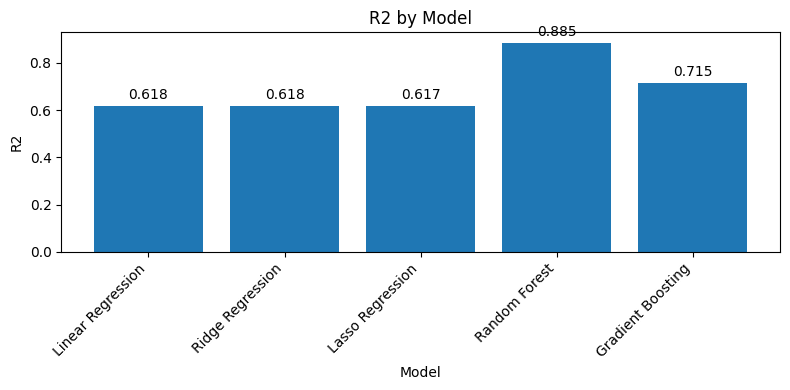

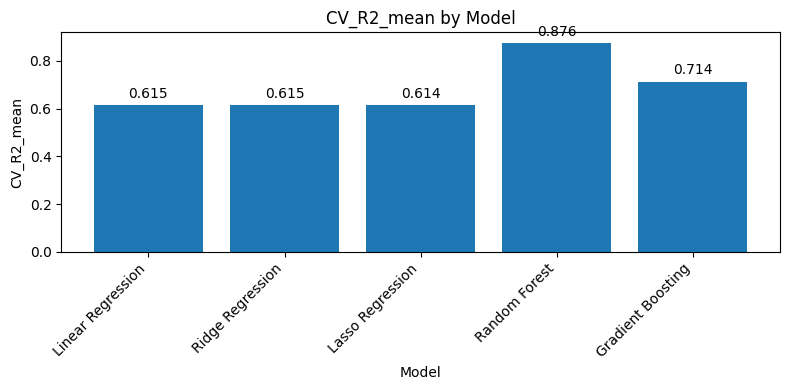

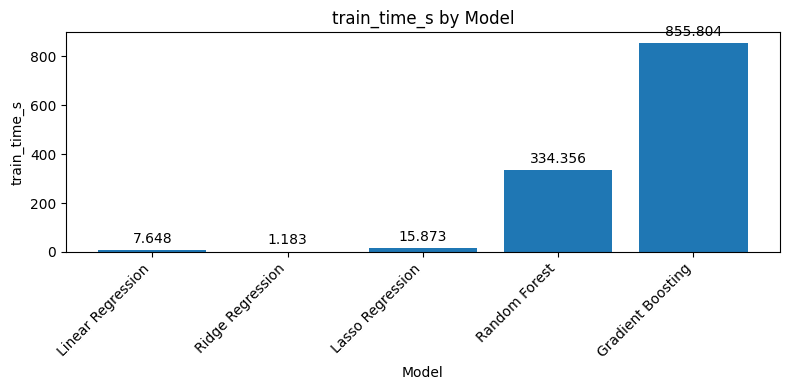

In [15]:
metrics = ['RMSE', 'MAE', 'R2', 'CV_R2_mean', 'train_time_s']

# 3) Loop over each metric and draw a bar chart
for metric in metrics:
    fig, ax = plt.subplots(figsize=(8, 4))
    # draw bars
    bars = ax.bar(results_df.index, results_df[metric])
    # add labels using bar_label
    ax.bar_label(bars, fmt='%.3f', padding=3)
    
    ax.set_title(f'{metric} by Model')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

## Recommendations

/var/folders/35/pbgws13x799_nyj0v06t0p6c0000gq/T/ipykernel_94337/2220878411.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_avg = df.groupby('age_bucket')['price'].mean()


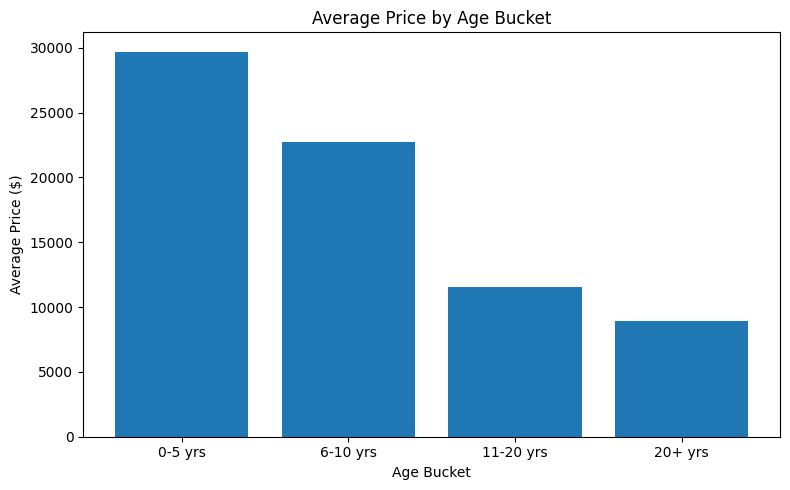

In [16]:
df['age'] = 2024 - df['year']
df['age_bucket'] = pd.cut(
    df['age'], bins=[-1, 5, 10, 20, np.inf],
    labels=['0-5 yrs', '6-10 yrs', '11-20 yrs', '20+ yrs']
)
df['mileage_bucket'] = np.where(
    df['odometer'] <= 60000, '≤60k miles', '>60k miles'
)
df['maker_group'] = df['manufacturer'].str.lower().apply(
    lambda x: x if x in ['toyota', 'honda'] else 'Other'
)

# 1) Average Price by Age Bucket
age_avg = df.groupby('age_bucket')['price'].mean()
plt.figure(figsize=(8, 5))
plt.bar(age_avg.index.astype(str), age_avg.values)
plt.xlabel('Age Bucket')
plt.ylabel('Average Price ($)')
plt.title('Average Price by Age Bucket')
plt.tight_layout()
plt.show()

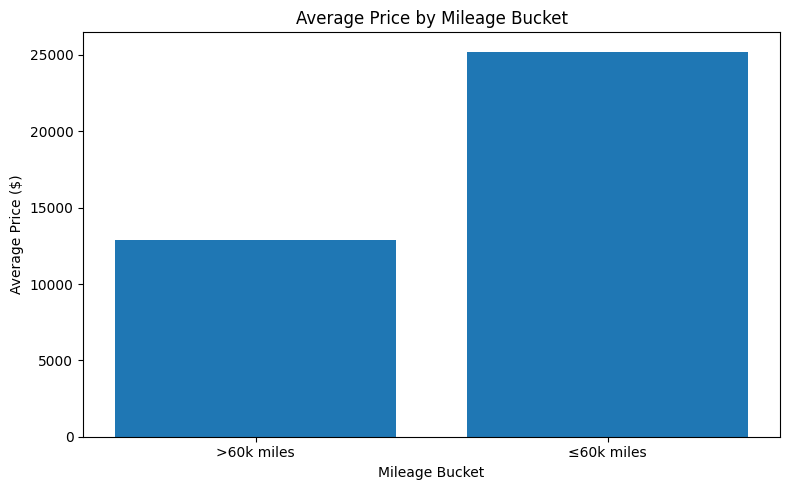

In [17]:
# 2) Average Price by Mileage Bucket
mile_avg = df.groupby('mileage_bucket')['price'].mean()
plt.figure(figsize=(8, 5))
plt.bar(mile_avg.index.astype(str), mile_avg.values)
plt.xlabel('Mileage Bucket')
plt.ylabel('Average Price ($)')
plt.title('Average Price by Mileage Bucket')
plt.tight_layout()
plt.show()

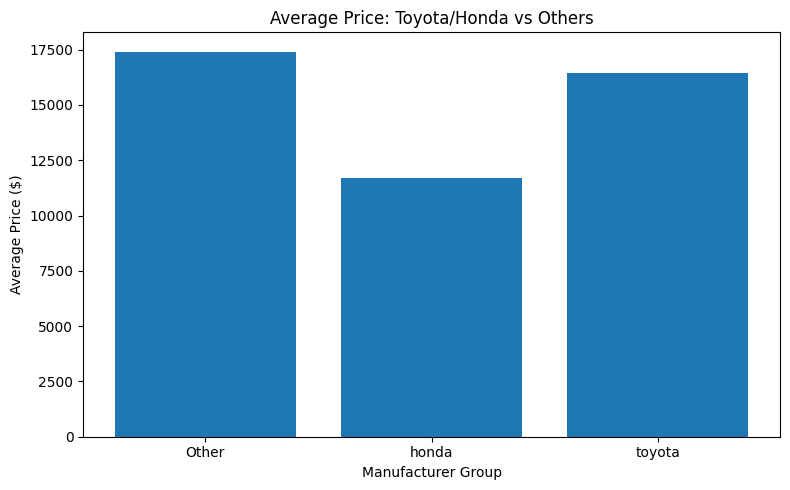

In [18]:
# 3) Average Price: Toyota/Honda vs Others
maker_avg = df.groupby('maker_group')['price'].mean()
plt.figure(figsize=(8, 5))
plt.bar(maker_avg.index.astype(str), maker_avg.values)
plt.xlabel('Manufacturer Group')
plt.ylabel('Average Price ($)')
plt.title('Average Price: Toyota/Honda vs Others')
plt.tight_layout()
plt.show()